In [92]:
import os
import warnings
from pathlib import Path
import requests
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Dropout,GRU
from keras.backend import clear_session
from keras.metrics import RootMeanSquaredError
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import schedules,SGD
import tensorflow as tf

warnings.simplefilter('ignore')
plt.style.use('fivethirtyeight')


In [93]:

def create_dataset(data, window_size,target_column_index):
    X, y = [], []

    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size,target_column_index])

    return np.array(X), np.array(y)

#### Hyperparameter Tuning

In [94]:
def lstm_hyperparameter_tuning(config,
                               target_column, X_train, y_train, X_test, y_test
                               ):
  first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = config
  possible_combinations = list(itertools.product(first_additional_layer, second_additional_layer, third_additional_layer,
                                                  n_neurons, n_batch_size, dropout))

  print(possible_combinations)

  print('\n')

  hist = []
  for i in range(0,len(possible_combinations)):
    print(f'{i+1}th combination: \n')
    print(50*'-')
    first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = possible_combinations[i]
    model = Sequential()
    model.add(LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout))

    if first_additional_layer:
      model.add(LSTM(units=n_neurons, return_sequences=True))
      model.add(Dropout(dropout))

    if second_additional_layer:
      model.add(LSTM(units=n_neurons, return_sequences=True))
      model.add(Dropout(dropout))

    if third_additional_layer:
      model.add(GRU(units=n_neurons, return_sequences=True))
      model.add(Dropout(dropout))

    model.add(LSTM(units=n_neurons, return_sequences=False))
    model.add(Dropout(dropout))
    model.add(Dense(units=1, activation='linear'))
    model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

    #model save
    file_path = 'best_model.h5'
    mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

    model.fit(X_train,
              y_train,
              validation_split=0.3,
              epochs=40,
              batch_size=n_batch_size,
              callbacks=[es, mc],
              verbose=0)

    train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    test_accuracy = model.evaluate(X_test, y_test, verbose=0)


    hist.append(list((first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout,
                          train_accuracy, test_accuracy)))


    #loss_value = test_accuracy[0]  # First element is the loss
    #accuracy_value = test_accuracy[1]  # Second element is the accuracy (or other specified metric)

    print(f'{str(i+1)}-th combination = {possible_combinations[i]} \n Training Loss: {train_accuracy[0]} (MSE), Training Accuracy: {train_accuracy[1]} \n Test Loss: {test_accuracy[0]} (MSE), Test Accuracy: {test_accuracy[1]}')

    print('--------------------------------------------------------------------')
    print('--------------------------------------------------------------------')
    print('--------------------------------------------------------------------')
    print('--------------------------------------------------------------------')

  return hist


In [107]:
config = [[False], [False], [False], [16, 32, 64], [8, 16, 32], [0.1,0.2]]
target_columns=["MPN1P","MPN2P","MPN3P","MPN4P","MPN5P","MPN6P","MPN7P","MPN10P","MPN20P"]

data_path = 'dataset.csv'
window_size = 60
train_end = '2022-10-28'

df = pd.read_csv(
    data_path,
    parse_dates=['Date']
).drop('Unnamed: 0', axis=1)

data = df.copy()

df_train = df.loc[df.Date <= train_end][window_size:]
df_test = df.loc[df.Date > train_end][window_size:]


In [108]:
data.columns

Index(['Date', 'DNCP', 'OPCP', 'HPCP', 'LPCP', 'CPCP', 'ACPCP', 'VTCP',
       'MPN1P', 'MPN2P', 'MPN3P', 'MPN4P', 'MPN6P', 'MPN5P', 'MPN7P', 'MPN10P',
       'MPN20P', 'HPN1P', 'LPN1P'],
      dtype='object')

In [109]:
train = data.loc[data.Date <= train_end].set_index('Date').values.astype('float32')
train[0]

array([-3.3668368 ,  0.60273445,  0.611564  ,  0.57699156,  0.59512836,
        0.3295252 , -0.3701642 ,  0.5774933 ,  0.56967676,  0.5681448 ,
        0.5660934 ,  0.56150734,  0.565176  ,  0.5559074 ,  0.55988073,
        0.5074957 ,  0.5965902 ,  0.567925  ], dtype=float32)

In [110]:
test = data.loc[data.Date > train_end].set_index('Date').values.astype('float32')
test[0]

array([ 0.95299095,  2.2948222 ,  2.305123  ,  2.2776585 ,  2.2805567 ,
        2.0221052 , -0.36339265,  2.278184  ,  2.2706032 ,  2.270853  ,
        2.2611458 ,  2.267395  ,  2.2617946 ,  2.2743762 ,  2.2880766 ,
        2.3348947 ,  2.2931662 ,  2.2634666 ], dtype=float32)

In [111]:
# Loop through each target column and perform hyperparameter tuning
results = {}
all_combinations = []

for target_column in target_columns:
    target_column_index=7
    print(f"Working on target column: {target_column}")

    train = data.loc[data.Date <= train_end].set_index('Date').values.astype('float32')
    test = data.loc[data.Date > train_end].set_index('Date').values.astype('float32')


    X_train, y_train = create_dataset(train, window_size=window_size,target_column_index=target_column_index)
    X_test, y_test = create_dataset(test, window_size=window_size,target_column_index=target_column_index)

    #print(f'X_train shape {X_train.shape}, y_train shape {y_train.shape}')
    #print(f'X_test shape {X_test.shape}, y_test shape {y_test.shape}')



    # Call your hyperparameter tuning function for this target column
    hist = lstm_hyperparameter_tuning(config,target_column, X_train, y_train, X_test, y_test)

    # Store the results in the dictionary
    results[target_column] = hist
    target_column_index+=1
    all_combinations.extend([hist,target_column])

# Print or analyze the results for each target column
for target_column, hist in results.items():
    print(f'Results for target column: {target_column}')
    for i, result in enumerate(hist):
        first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout, train_accuracy, test_accuracy = result
        #print(f'{i + 1}-th combination = {result}')
        #print(f'Train accuracy: {train_accuracy} and test accuracy: {test_accuracy}')
    #print('\n')

Görüntülenen çıkış son 5000 satıra kısaltıldı.

Epoch 3: val_loss improved from 0.66934 to 0.58001, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.58001

Epoch 5: val_loss improved from 0.58001 to 0.51407, saving model to best_model.h5

Epoch 6: val_loss improved from 0.51407 to 0.47126, saving model to best_model.h5

Epoch 7: val_loss improved from 0.47126 to 0.38696, saving model to best_model.h5

Epoch 8: val_loss improved from 0.38696 to 0.31968, saving model to best_model.h5

Epoch 9: val_loss did not improve from 0.31968

Epoch 10: val_loss did not improve from 0.31968

Epoch 11: val_loss did not improve from 0.31968

Epoch 12: val_loss did not improve from 0.31968

Epoch 13: val_loss did not improve from 0.31968
Epoch 13: early stopping
9-th combination = (False, False, False, 32, 16, 0.1) 
 Training Loss: 0.1028483435511589 (MSE), Training Accuracy: 0.3206997811794281 
 Test Loss: 1.138461947441101 (MSE), Test Accuracy: 1.0669872760772705
--------------

In [112]:
hist_sort = pd.DataFrame(results['MPN1P'])
hist_sort[8] = "MPN1P"

hist_sort2 = pd.DataFrame(results['MPN2P'])
hist_sort2[8] = "MPN2P"

hist_sort3 = pd.DataFrame(results['MPN3P'])
hist_sort3[8] = "MPN3P"

hist_sort4 = pd.DataFrame(results['MPN4P'])
hist_sort4[8] = "MPN4P"

hist_sort5 = pd.DataFrame(results['MPN5P'])
hist_sort5[8] = "MPN5P"

hist_sort6 = pd.DataFrame(results['MPN6P'])
hist_sort6[8] = "MPN6P"

hist_sort7 = pd.DataFrame(results['MPN7P'])
hist_sort7[8] = "MPN7P"

hist_sort8 = pd.DataFrame(results['MPN10P'])
hist_sort8[8] = "MPN10P"

hist_sort9 = pd.DataFrame(results['MPN20P'])
hist_sort9[8] = "MPN20P"


Training Loss: {train_accuracy[0]} (MSE), Training Accuracy: {train_accuracy[1]} \n Test Loss: {test_accuracy[0]} (MSE), Test Accuracy: {test_accuracy[1]}

In [113]:


frames = [hist_sort, hist_sort2,hist_sort3,hist_sort4,hist_sort5,hist_sort6,hist_sort7,hist_sort8,hist_sort9]

hist_res = pd.concat(frames)
hist_res = hist_res.sort_values(by=[7], ascending=True)
hist_res.reset_index()

,index,0,1,2,3,4,5,6,7,8
0,14,False,False,False,64,16,0.1,"[0.027233261615037918, 0.1650250256061554]","[0.36024925112724304, 0.6002076864242554]",MPN4P
1,16,False,False,False,64,32,0.1,"[0.028126893565058708, 0.16771073639392853]","[0.37839919328689575, 0.6151415705680847]",MPN6P
2,16,False,False,False,64,32,0.1,"[0.03509356081485748, 0.18733276426792145]","[0.4459037482738495, 0.6677602529525757]",MPN1P
3,16,False,False,False,64,32,0.1,"[0.03802461549639702, 0.19499900937080383]","[0.46107017993927, 0.6790214776992798]",MPN7P
4,17,False,False,False,64,32,0.2,"[0.040886763483285904, 0.20220474898815155]","[0.49415352940559387, 0.7029605507850647]",MPN5P
...,...,...,...,...,...,...,...,...,...,...
157,0,False,False,False,16,8,0.1,"[0.27821996808052063, 0.5274655818939209]","[2.653632879257202, 1.6289974451065063]",MPN10P
158,1,False,False,False,16,8,0.2,"[0.2790566086769104, 0.5282580852508545]","[2.67240309715271, 1.6347485780715942]",MPN20P
159,3,False,False,False,16,16,0.2,"[0.2787204682826996, 0.5279397964477539]","[2.6727452278137207, 1.6348532438278198]",MPN6P
160,1,False,False,False,16,8,0.2,"[0.29618746042251587, 0.5442310571670532]","[2.756244659423828, 1.6601941585540771]",MPN3P


### Plot the test and training loss

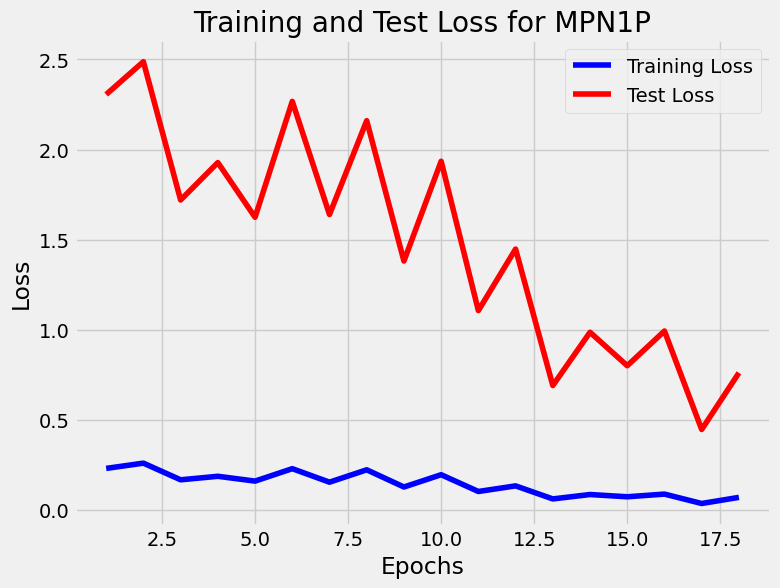

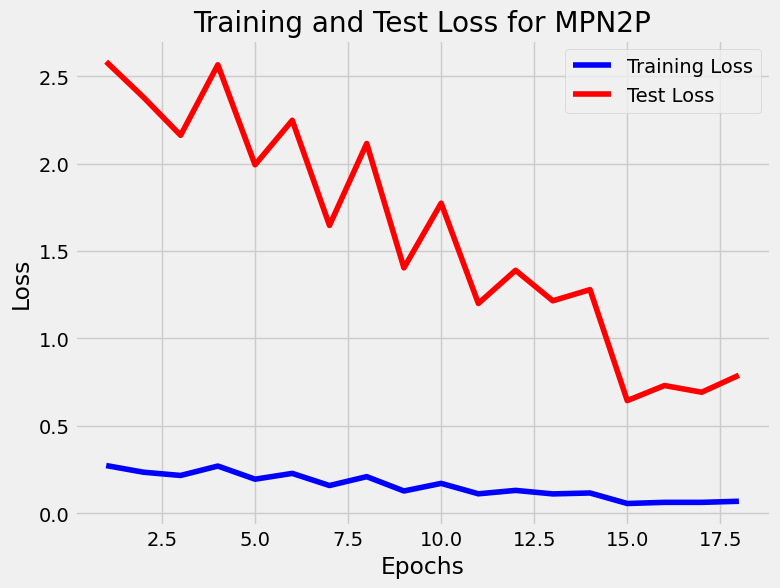

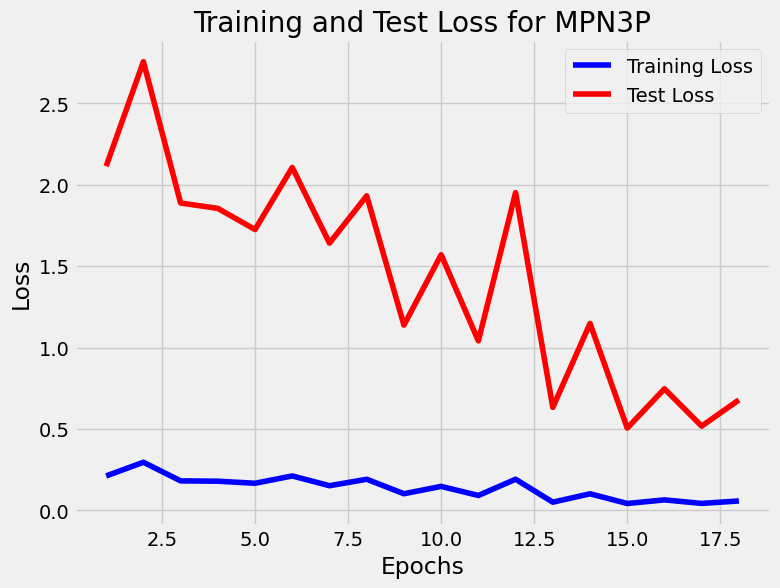

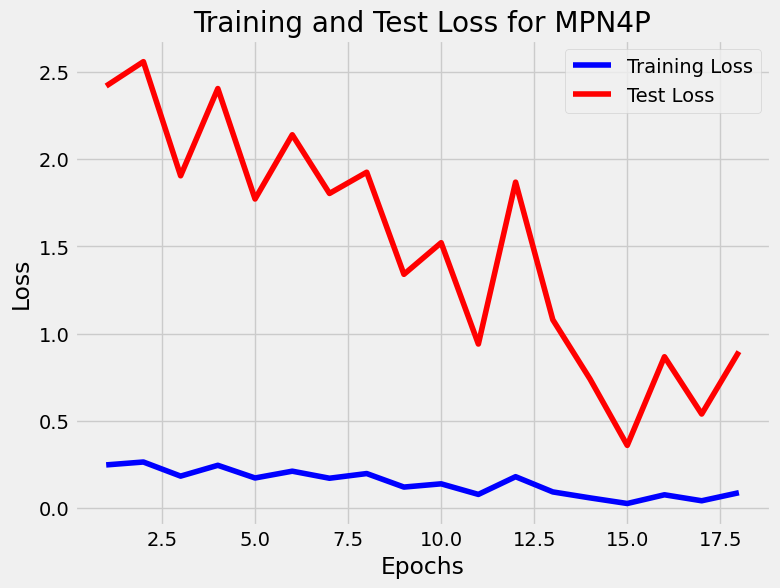

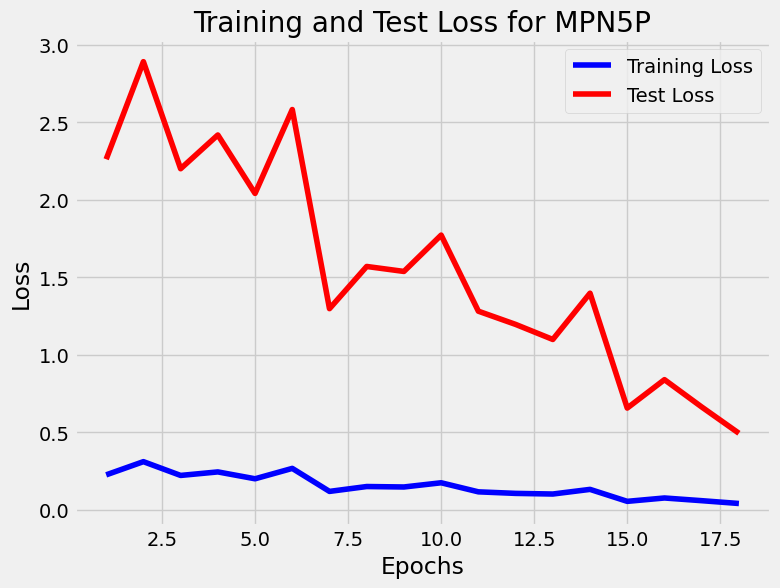

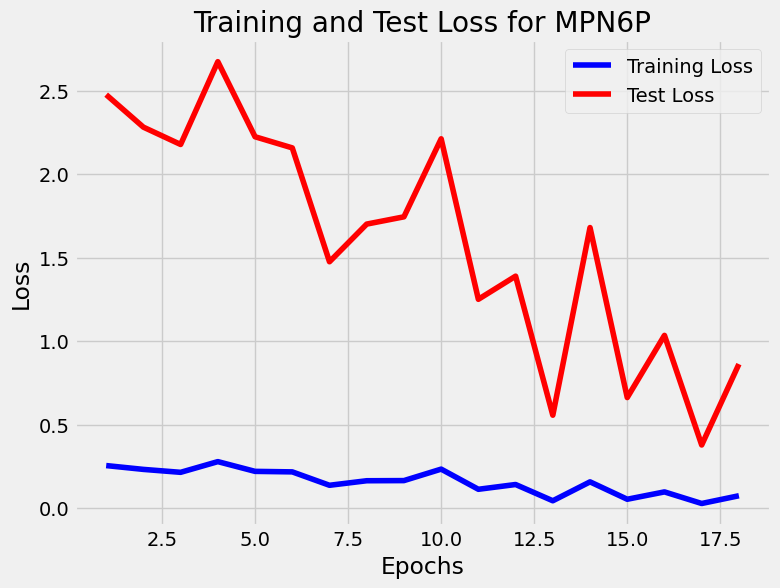

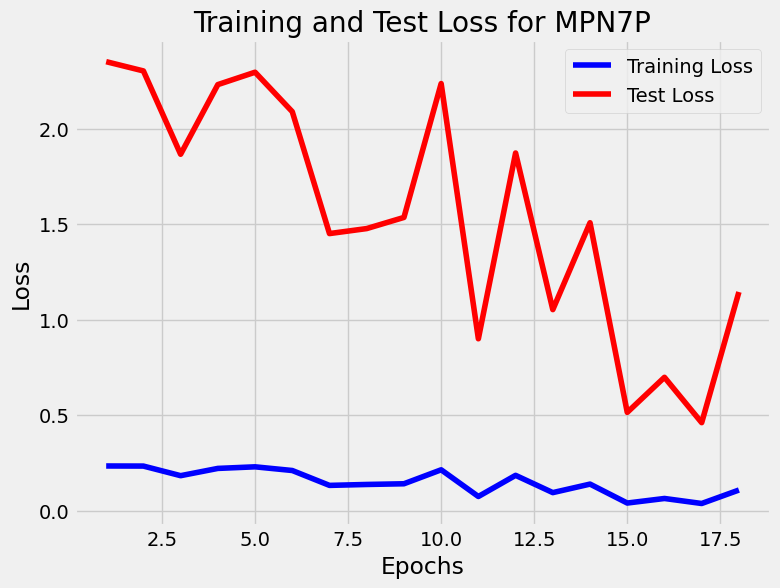

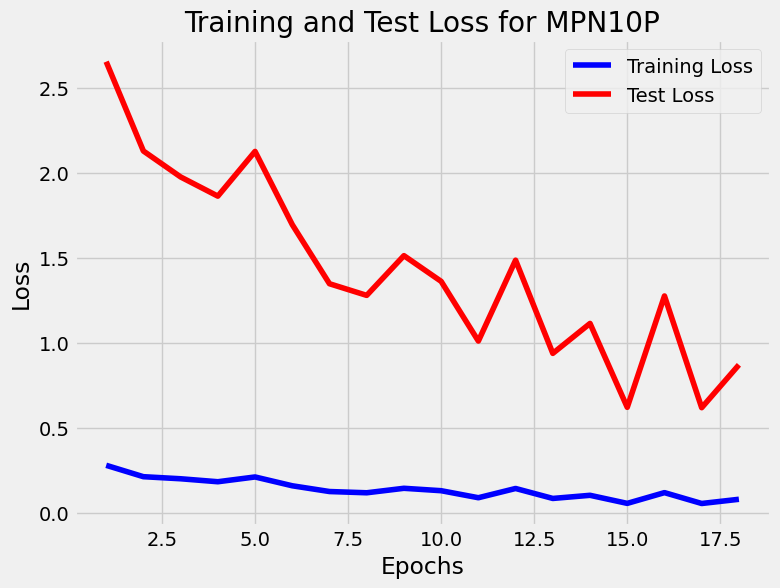

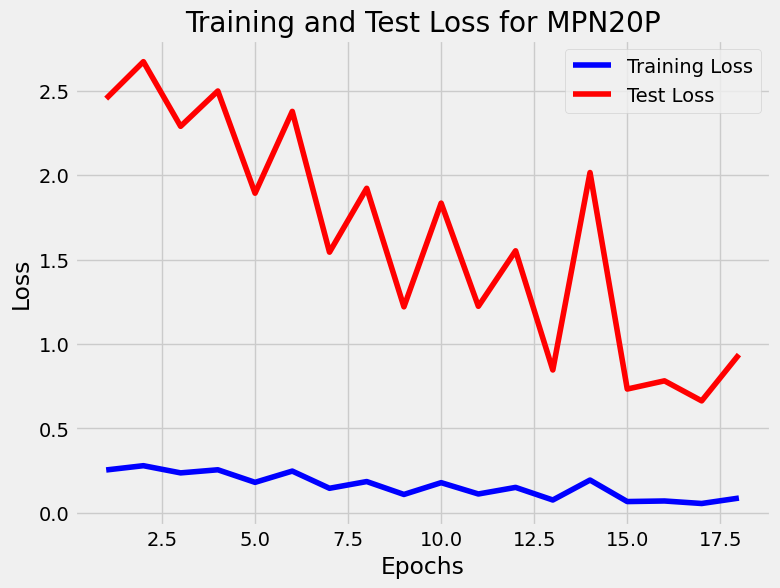

In [139]:
import matplotlib.pyplot as plt
col_num = 0
for each_col in frames:
  training_loss = []
  for i in each_col[6]:
    training_loss.append(i[0])



  test_loss=[]
  for i in each_col[7]:
    test_loss.append(i[0])

  # Number of epochs (or iterations)
  epochs = range(1, len(training_loss) + 1)


  # Create the plot for MPN4P
  plt.figure(figsize=(8, 6))
  plt.plot(epochs, training_loss, 'b', label='Training Loss')
  plt.plot(epochs, test_loss, 'r', label='Test Loss')
  plt.title(f'Training and Test Loss for {target_columns[col_num]}')
  col_num+=1
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.grid(True)

  # Show the plot
  plt.show()


these all means that the model does not generalize well. It's overfitting

#### Define and Train Best Combination

In [154]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist_res.iloc[0, :-3])
print(first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout)

False False False 64 16 0.1


In [155]:
first_additional_layer, second_additional_layer, third_additional_layer, n_neurons, n_batch_size, dropout = list(hist_res.iloc[0, :-3])

#clear_session()

model = Sequential([
    LSTM(units=n_neurons, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(dropout)
])

if first_additional_layer:
    model.add(LSTM(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))

if second_additional_layer:
    model.add(LSTM(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))

if third_additional_layer:
    model.add(GRU(units=n_neurons, return_sequences=True))
    model.add(Dropout(dropout))


model.add(LSTM(units=n_neurons, return_sequences=False))
model.add(Dropout(dropout))
model.add(Dense(units=1, activation='linear'))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])

model.summary()

Model: "sequential_271"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_542 (LSTM)             (None, 60, 64)            21248     
                                                                 
 dropout_542 (Dropout)       (None, 60, 64)            0         
                                                                 
 lstm_543 (LSTM)             (None, 64)                33024     
                                                                 
 dropout_543 (Dropout)       (None, 64)                0         
                                                                 
 dense_271 (Dense)           (None, 1)                 65        
                                                                 
Total params: 54337 (212.25 KB)
Trainable params: 54337 (212.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [142]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

file_path = 'best_model.h5'
mc = ModelCheckpoint(file_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)


hist_best = model.fit(X_train,
              y_train,
              validation_split=0.3,
              epochs=50,
              batch_size=n_batch_size,
              callbacks=[es, mc],
              verbose=0)


Epoch 1: val_loss improved from inf to 0.62416, saving model to best_model.h5

Epoch 2: val_loss improved from 0.62416 to 0.48263, saving model to best_model.h5

Epoch 3: val_loss improved from 0.48263 to 0.30494, saving model to best_model.h5

Epoch 4: val_loss did not improve from 0.30494

Epoch 5: val_loss did not improve from 0.30494

Epoch 6: val_loss improved from 0.30494 to 0.15581, saving model to best_model.h5

Epoch 7: val_loss improved from 0.15581 to 0.15114, saving model to best_model.h5

Epoch 8: val_loss did not improve from 0.15114

Epoch 9: val_loss did not improve from 0.15114

Epoch 10: val_loss did not improve from 0.15114

Epoch 11: val_loss did not improve from 0.15114

Epoch 12: val_loss did not improve from 0.15114
Epoch 12: early stopping


In [145]:
hist_best.history

{'loss': [0.002433057175949216,
  0.0005288163665682077,
  0.0004504509561229497,
  0.00038868270348757505,
  0.0003096050932072103,
  0.0003421893634367734,
  0.0003230844740755856,
  0.000294587662210688,
  0.00033262462238781154,
  0.0002682211634237319,
  0.00036899137194268405,
  0.0002942037826869637],
 'root_mean_squared_error': [0.04932602867484093,
  0.022996006533503532,
  0.021223830059170723,
  0.01971503719687462,
  0.017595598474144936,
  0.018498361110687256,
  0.017974549904465675,
  0.017163556069135666,
  0.018237998709082603,
  0.016377458348870277,
  0.01920914836227894,
  0.017152369022369385],
 'val_loss': [0.6241621971130371,
  0.4826306104660034,
  0.30493634939193726,
  0.35609304904937744,
  0.35010623931884766,
  0.15580543875694275,
  0.1511439085006714,
  0.24378466606140137,
  0.18387052416801453,
  0.17981940507888794,
  0.19705812633037567,
  0.17217840254306793],
 'val_root_mean_squared_error': [0.7900393605232239,
  0.694716215133667,
  0.5522103905677

In [ ]:
hist_best.history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

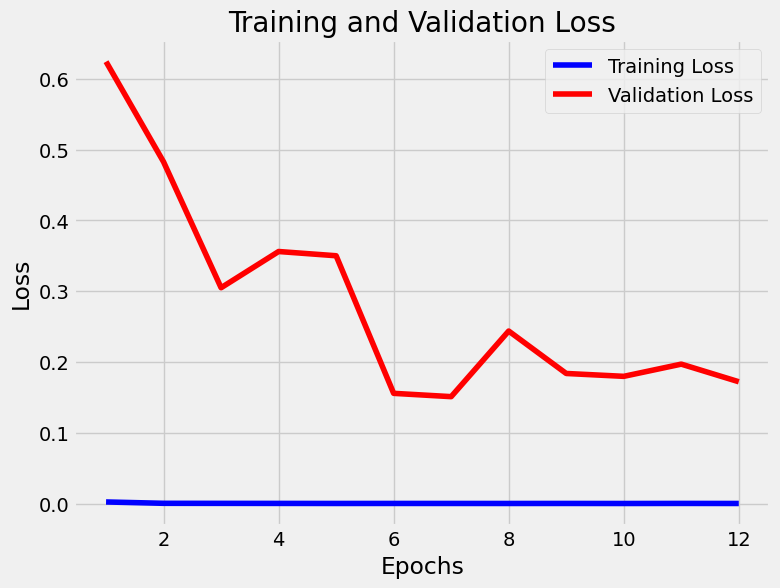

In [151]:
import matplotlib.pyplot as plt

# Access the training and validation loss values from the history object
training_loss = hist_best.history['loss']
validation_loss = hist_best.history['val_loss']

# Number of epochs (or iterations)
epochs = range(1, len(training_loss) + 1)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, training_loss, 'b', label='Training Loss')
plt.plot(epochs, validation_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:

fitted = model.predict(X_train).flatten()
preds = model.predict(X_test).flatten()

df_train['Forecasts'] = fitted
df_test['Forecasts'] = preds

train_rmse = np.sqrt(mean_squared_error(df_train['MPN6P'].tolist(),df_train['Forecasts'].tolist()))
test_rmse = np.sqrt(mean_squared_error(df_test['MPN6P'].tolist(), df_test['Forecasts'].tolist()))

print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

4/4 [==============================] - 0s 4ms/step
Train RMSE: 0.2556793936594132
Test RMSE: 0.8538804936815421


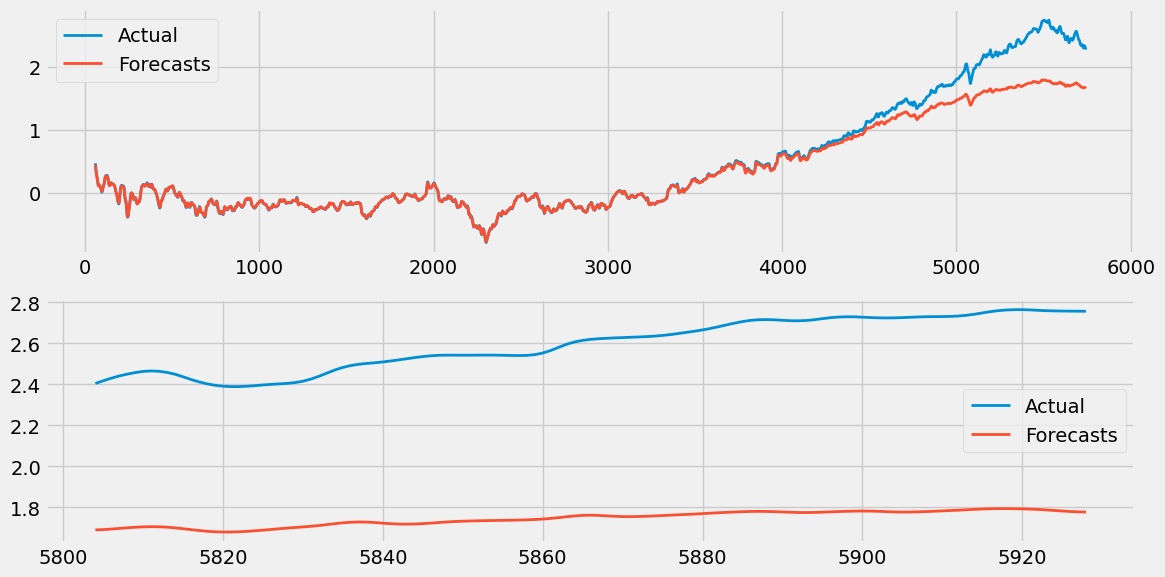

In [ ]:
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(12,6))

df_train.MPN6P.plot(ax=ax1,linewidth=2,label='Actual')
df_train.Forecasts.plot(ax=ax1,linewidth=2,label='Forecasts')
ax1.legend()

df_test.MPN6P.plot(ax=ax2,linewidth=2, label='Actual')
df_test.Forecasts.plot(ax=ax2,linewidth=2, label='Forecasts')
ax2.legend()

fig.tight_layout()